<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

In [2]:
import seaborn as sns
from scipy.stats import ttest_ind

In [3]:
# datos
df = pd.read_csv('data/cookie_cats.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
sesiones=df.userid.value_counts(ascending=False)
sesiones[sesiones>1].count() # 0 -> No hay usuarios duplicados por lo que o son gate 30 o 40

0

# Frequentista

In [6]:
# muestreo
## exp 1
control_1 = df[['version', 'sum_gamerounds','retention_1']][df.version=='gate_30']
tratamiento_1 = df[['version', 'sum_gamerounds','retention_1']][df.version=='gate_40']

## exp 2
control_7 = df[['version', 'sum_gamerounds','retention_7']][df.version=='gate_30']
tratamiento_7 = df[['version', 'sum_gamerounds','retention_7']][df.version=='gate_40']

In [7]:
print(ttest_ind(control_1.sum_gamerounds, tratamiento_1.sum_gamerounds))
print(ttest_ind(control_7.sum_gamerounds, tratamiento_7.sum_gamerounds))

Ttest_indResult(statistic=0.8910426211362967, pvalue=0.37290868247405207)
Ttest_indResult(statistic=0.8910426211362967, pvalue=0.37290868247405207)


In [8]:
### Las muestras de control y tratamiento son independientes porque su pvalue es próximo a 0

In [9]:
# testeo para retention_1

ab_test = pd.concat([control_1, tratamiento_1], axis=0)
ab_test.reset_index(drop=True, inplace=True)


tasas_conversion_1=ab_test.groupby('version')['retention_1']  # agrupo por grupo

std=lambda x: np.std(x, ddof=0)    # std
error_std=lambda x: sem(x, ddof=0)   # error standard , (std/sqrt(n))


tasas_conversion_1=tasas_conversion_1.agg([np.mean, std, error_std])
tasas_conversion_1.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion_1.style.format('{:.3f}')

,conversion_rate,std,std_error
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.442,0.497,0.002


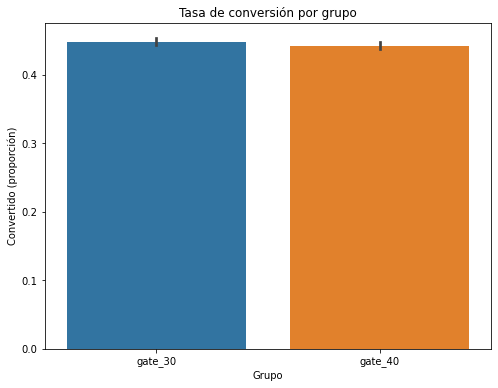

In [10]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_1'])


plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

In [11]:
# testeo para retention_7
ab_test_2 = pd.concat([control_7, tratamiento_7], axis=0)
ab_test_2.reset_index(drop=True, inplace=True)


tasas_conversion_7=ab_test_2.groupby('version')['retention_7']  # agrupo por grupo

std=lambda x: np.std(x, ddof=0)    # std
error_std=lambda x: sem(x, ddof=0)   # error standard , (std/sqrt(n))


tasas_conversion_7=tasas_conversion_7.agg([np.mean, std, error_std])
tasas_conversion_7.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion_7.style.format('{:.3f}')


,conversion_rate,std,std_error
version,,,
gate_30,0.190,0.392,0.002
gate_40,0.182,0.386,0.002


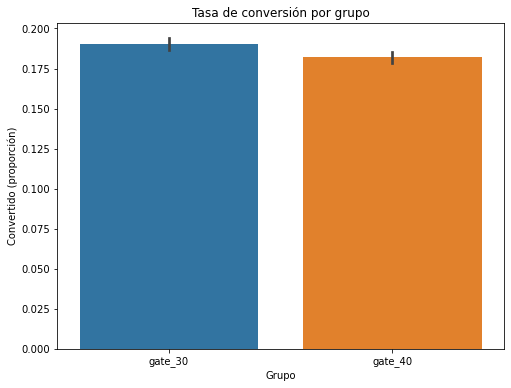

In [12]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test_2['version'], 
            y=ab_test_2['retention_7'])


plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

In [13]:
control_1_res=ab_test[ab_test.version=='gate_30']['retention_1']

trat_1_res=ab_test[ab_test.version=='gate_40']['retention_1']


observaciones = [control_1_res.count(), trat_1_res.count()]  #control_res.count()

conversiones=[control_1_res.sum(), trat_1_res.sum()]  # conversiones por grupo

z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones)


# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, 
                                                                            nobs=observaciones,
                                                                            alpha=0.05)
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 1.78
p-valor: 0.074
intervalo conf 95% para grupo control: [0.444, 0.453]
intervalo conf 95% para grupo tratamiento: [0.438, 0.447]


In [14]:
control_7_res=ab_test_2[ab_test_2.version=='gate_30']['retention_7']

trat_7_res=ab_test_2[ab_test_2.version=='gate_40']['retention_7']

observaciones = [control_7_res.count(), trat_7_res.count()]  #control_res.count()

conversiones=[control_7_res.sum(), trat_7_res.sum()]  # conversiones por grupo

z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones)


# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, 
                                                                            nobs=observaciones,
                                                                            alpha=0.05)
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 3.16
p-valor: 0.002
intervalo conf 95% para grupo control: [0.187, 0.194]
intervalo conf 95% para grupo tratamiento: [0.178, 0.186]


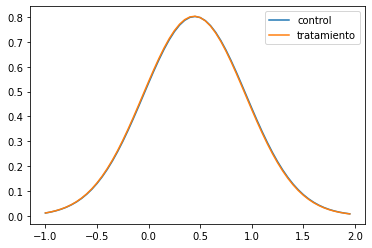

In [15]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.

x=[i*.05 for i in range(-20, 40)]  

control=[norm.pdf(x, tasas_conversion_1.iloc[0][0], tasas_conversion_1.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion_1.iloc[1][0], tasas_conversion_1.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);

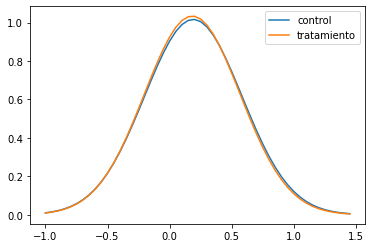

In [16]:
x=[i*.05 for i in range(-20, 30)]  

control=[norm.pdf(x, tasas_conversion_7.iloc[0][0], tasas_conversion_7.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion_7.iloc[1][0], tasas_conversion_7.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);

In [17]:
### Nuestra H0 y H1 son iguales para los experimentos 1 y 7

### H0: µ0(gate_30) = µ1 (gate_40)  
### H1: µ0(gate_30) ≠ µ1 (gate_40)

## Retention_1
### El valor de p es 0.074 -> Dado que supera 0.05, no podemos rechazar H0 y por tanto las medias
### de gate_30 y gate_40 no son significativamente distintas.

## Retention_7
### El valor de p es 0.002 -> Dado que NO supera 0.05, podemos rechazar H0 y por tanto las medias
### de gate_30 y gate_40 SI son significativamente distintas.


In [19]:
print(control_1.retention_1.mean(), tratamiento_1.retention_1.mean()) # No hay apenas diferencia

0.4481879194630872 0.44228274967574577


In [21]:
print(control_7.retention_7.mean(), tratamiento_7.retention_7.mean()) # Hay diferencia y la media de control es mayor

0.19020134228187918 0.18200004396667327


# Bayes